In [1]:
import symbolica
from symbolica import S, E, N
from IPython.display import display_latex, Latex
import matplotlib.pyplot as plt
import numpy as np
import integrand_builder
from evaluator_builder import WrappedEvaluator, plot_line, plot_slice
from symbolica_vectors import *

In [2]:
i = symbolica.Expression.I
q1, q2, p11, p12, p21, p22, m = S('q1','q2', 'p11', 'p12','p21','p22', 'm')
eps = S('e') #greek letters dont work as expected, therefore use e

def pcr(E, p):
    return 1/(E**2-p**2 - m**2 + i*eps)

integrand = -i * pcr(q1, q2)*pcr(q1+p11, q2+p12)*pcr(q1-p21, q2-p22)

display_latex(Latex(integrand.to_latex()))

In [3]:
integrand_eval = integrand.evaluator({
    m:      symbolica.Expression.num(0),
    eps:    symbolica.Expression.num(1)/1000,
    p11:    symbolica.Expression.num(1),
    p12:    symbolica.Expression.num(0),
    p21:    symbolica.Expression.num(1),
    p22:    symbolica.Expression.num(0),
},{},
    [q1, q2])

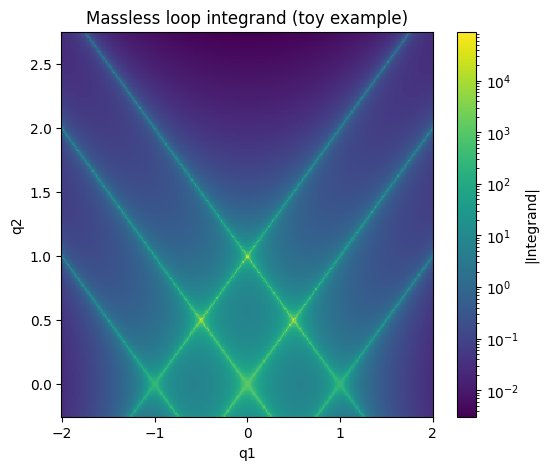

In [4]:
# Create a NumPy meshgrid for q1, q2
from matplotlib.colors import LogNorm


q1_vals = np.linspace(-2, 2, 300)
q2_vals = np.linspace(-0.25, 2.75, 300)
Q1, Q2 = np.meshgrid(q1_vals, q2_vals)

# Evaluate the integrand on the grid
Z = np.zeros_like(Q1, dtype=np.complex128)
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        Z[i,j] = integrand_eval.evaluate_complex([[Q1[i,j], Q2[i,j]]])[0][0]

# Plot the absolute value of the integrand
plt.figure(figsize=(6,5))
plt.pcolormesh(Q1, Q2, np.abs(Z), shading='auto', cmap='viridis', norm=LogNorm())
plt.colorbar(label='|Integrand|')
plt.xlabel('q1')
plt.ylabel('q2')
plt.title('Massless loop integrand (toy example)')
plt.show()

In [5]:
def plot_subtraction(term, ct, sub, lims2d = (-5,5,-5,5), lims1d = (-5,5)):
    
    #k1_x_eval = WrappedEvaluator(k2.symbols[0], params_symbols, params_values)
    #k1_y_eval = WrappedEvaluator(k2.symbols[1], params_symbols, params_values)
    #samples = np.random.random([20,2]) * 2 - 1
    #poles_x = np.array([k1_x_eval(np.array([x,y,0])) for (x,y) in samples])
    #poles_y = np.array([k1_y_eval(np.array([x,y,0])) for (x,y) in samples])
    #plt.scatter(poles_x, poles_y)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,3,1)
    plot_slice(term, lims = lims2d)
    
    
    plt.subplot(2,3,2)
    plot_slice(ct, lims = lims2d)
    plt.subplot(2,3,3)
    plot_slice(sub, lims = lims2d)

    x0 = np.array([0,0.1,0.1])
    x_hat = np.array([1,0,0])

    plt.subplot(2,3,4)
    plot_line(term,x0, x_hat, lims1d)
    plt.subplot(2,3,5)
    plot_line(ct,x0, x_hat, lims1d)
    plt.subplot(2,3,6)
    plot_line(sub,x0, x_hat, lims1d)
    plt.show()
    


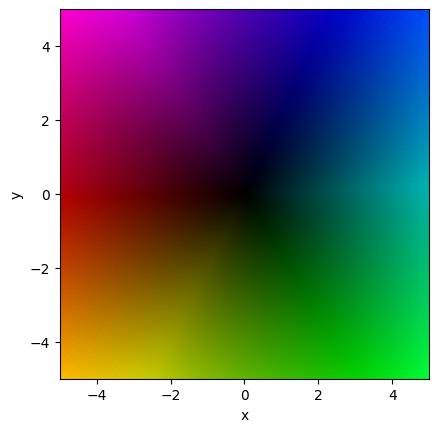

In [6]:
class Mock():
    def evaluate(self,args):
        k = args[0]
        return k[:,0] + k[:,1]*1j
plot_slice(Mock(), lims=(-5,5,-5,5))

In [7]:
integrand_builder.COUNTER_JACOBIAN = False
integrand_builder.LAMBDA = 1e10
integrand_builder.RELATIVE_LAMBDA = False

builder = integrand_builder.IntegrandBuilder()



p1 = np.array([4,-1,1, 0], dtype=complex)
p2 = np.array([4,-1,-1,  0], dtype=complex)

term = builder.improved_ltd_expression()
ct = builder.counter_term()

#eta = IntegrandEtaBuilder(builder, 1, 2)
#term = eta.eta(builder.integrand)
#(ct1,k1), (ct2,k2) = eta.counter_term(builder.integrand)
#ct = ct1+ct2

sub = term - ct

mass = 1-0.01j

contant_args = {symbolica.Expression.PI : complex(np.pi), builder.p1: p1, builder.p2: p2, builder.m : mass}

term_eval = WrappedEvaluator(term, contant_args, [builder.integrand], 'term')
ct_eval = WrappedEvaluator(ct, contant_args, [builder.integrand], 'ct')
sub_eval = WrappedEvaluator(sub, contant_args, [builder.integrand], 'sub')

Compiling evaluator: "term"
Done!
Compiling evaluator: "ct"
Done!
Compiling evaluator: "sub"
Done!


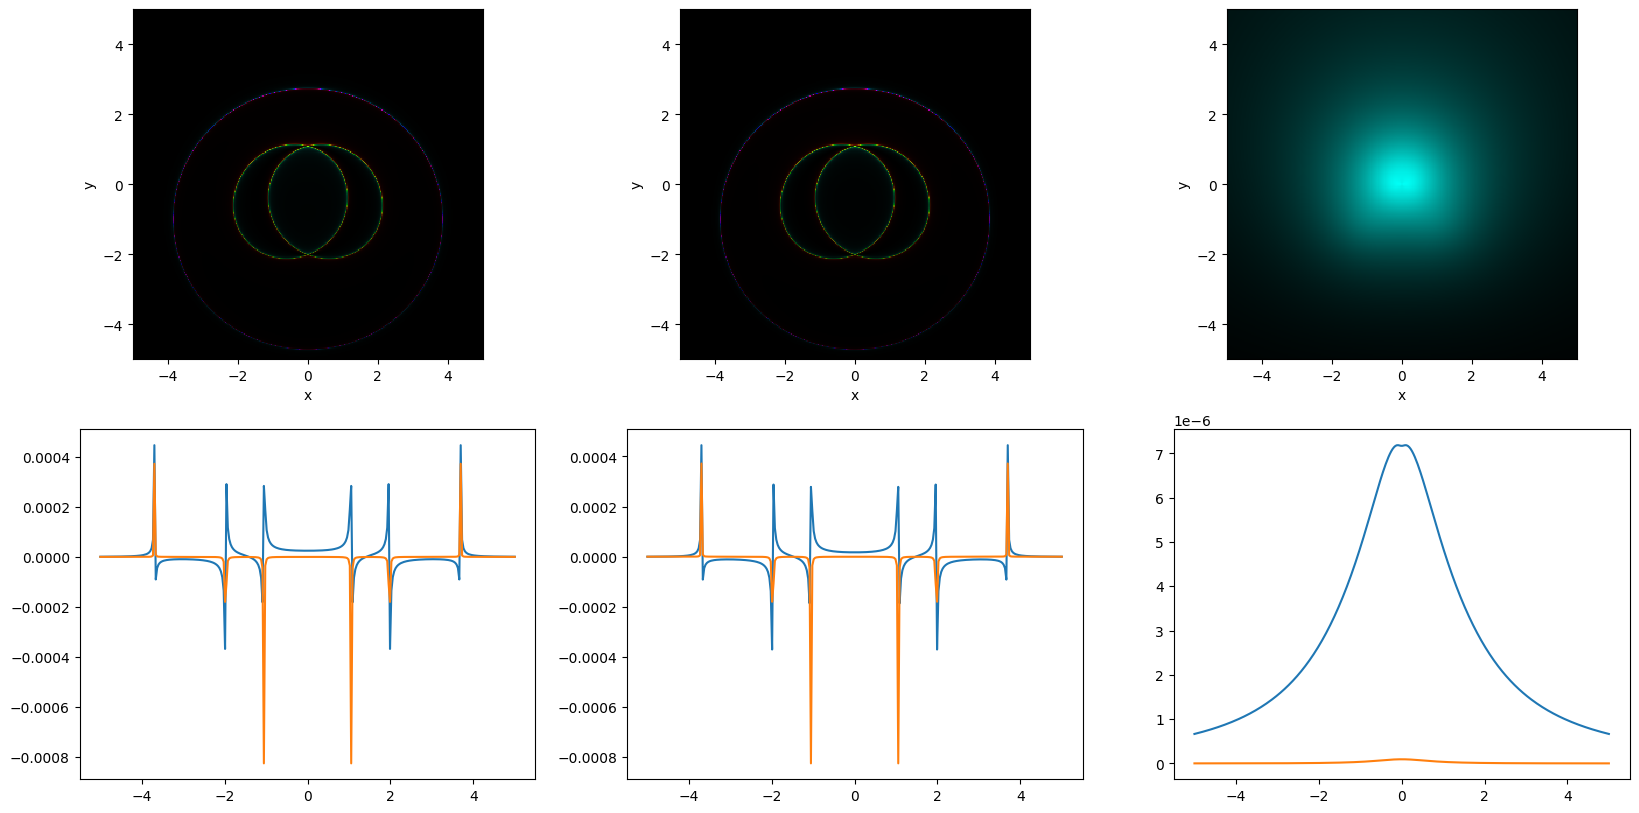

In [8]:
plot_subtraction(term_eval, ct_eval, sub_eval)

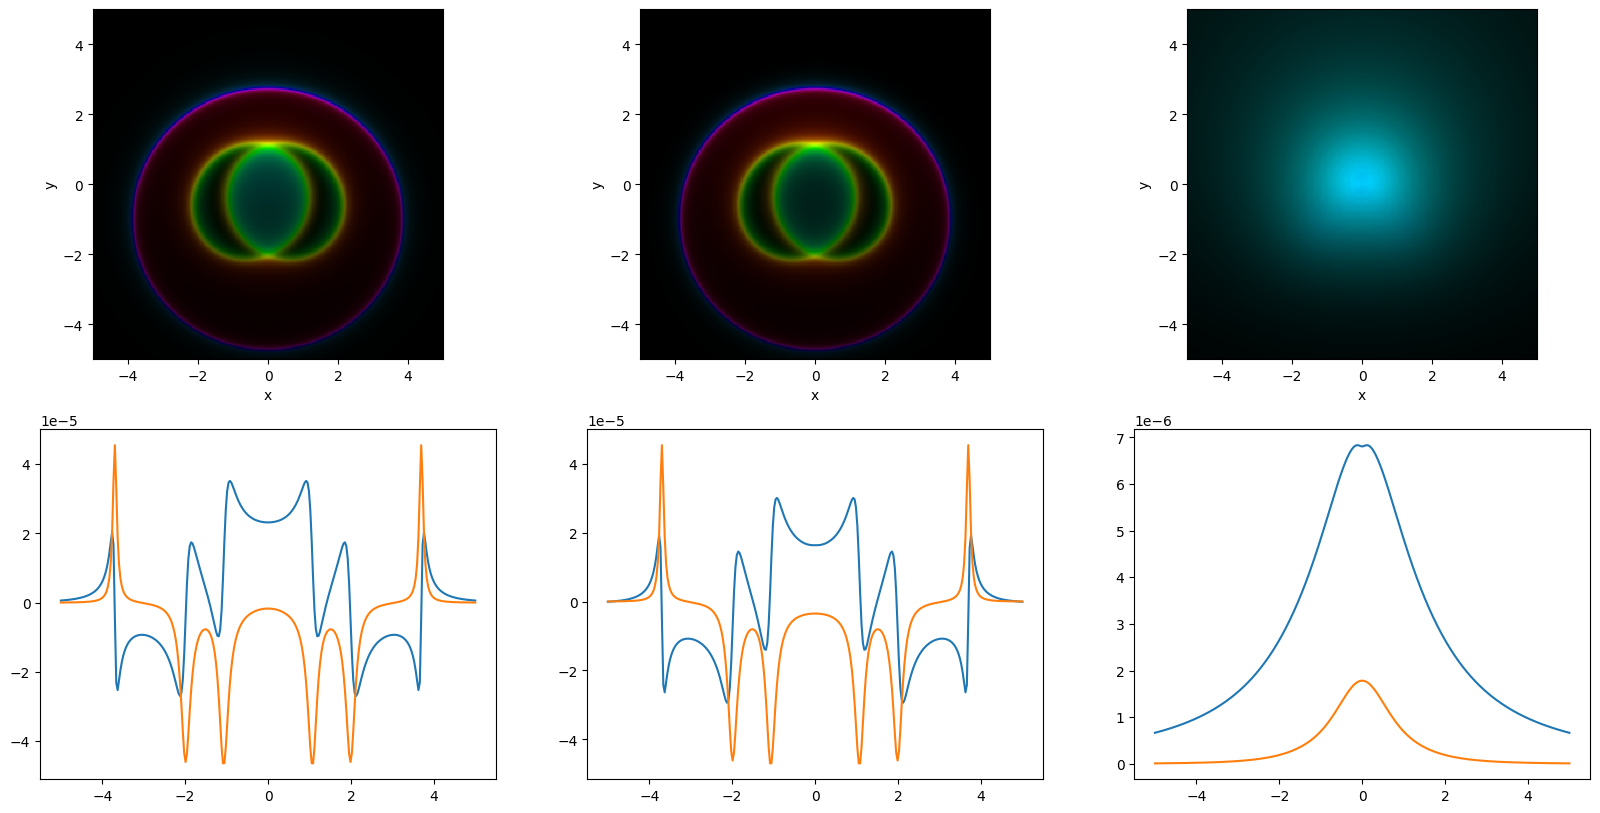

In [9]:
mass = 1-0.2j
term_eval.constant_args[m] = mass
ct_eval.constant_args[m] = mass
sub_eval.constant_args[m] = mass

plot_subtraction(term_eval,ct_eval,sub_eval)

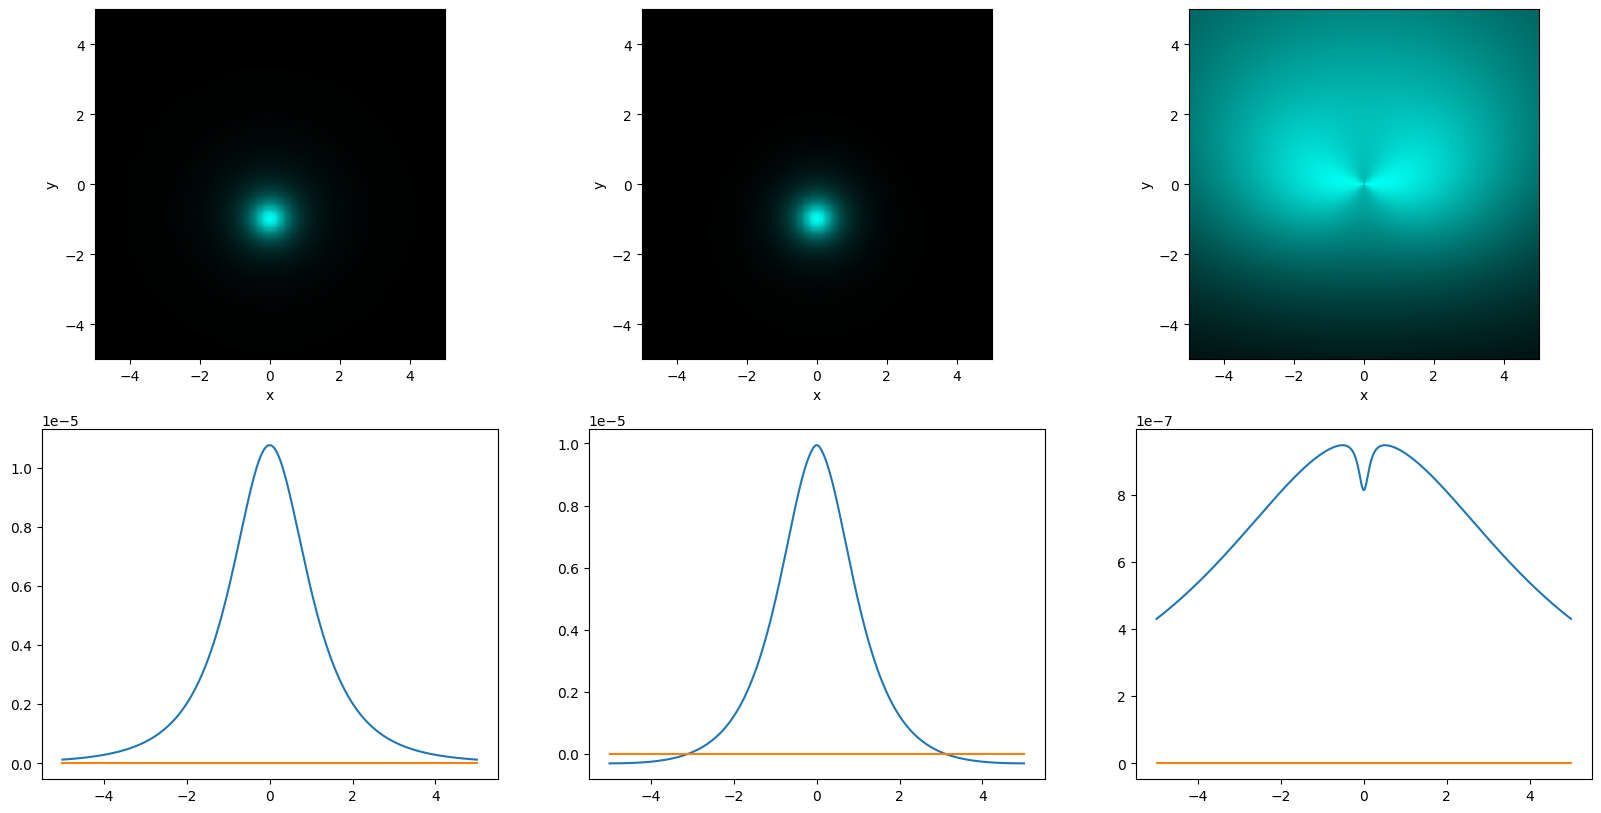

In [10]:
mass = 3.9
term_eval.constant_args[m] = mass
ct_eval.constant_args[m] = mass
sub_eval.constant_args[m] = mass

plot_subtraction(term_eval,ct_eval,sub_eval)

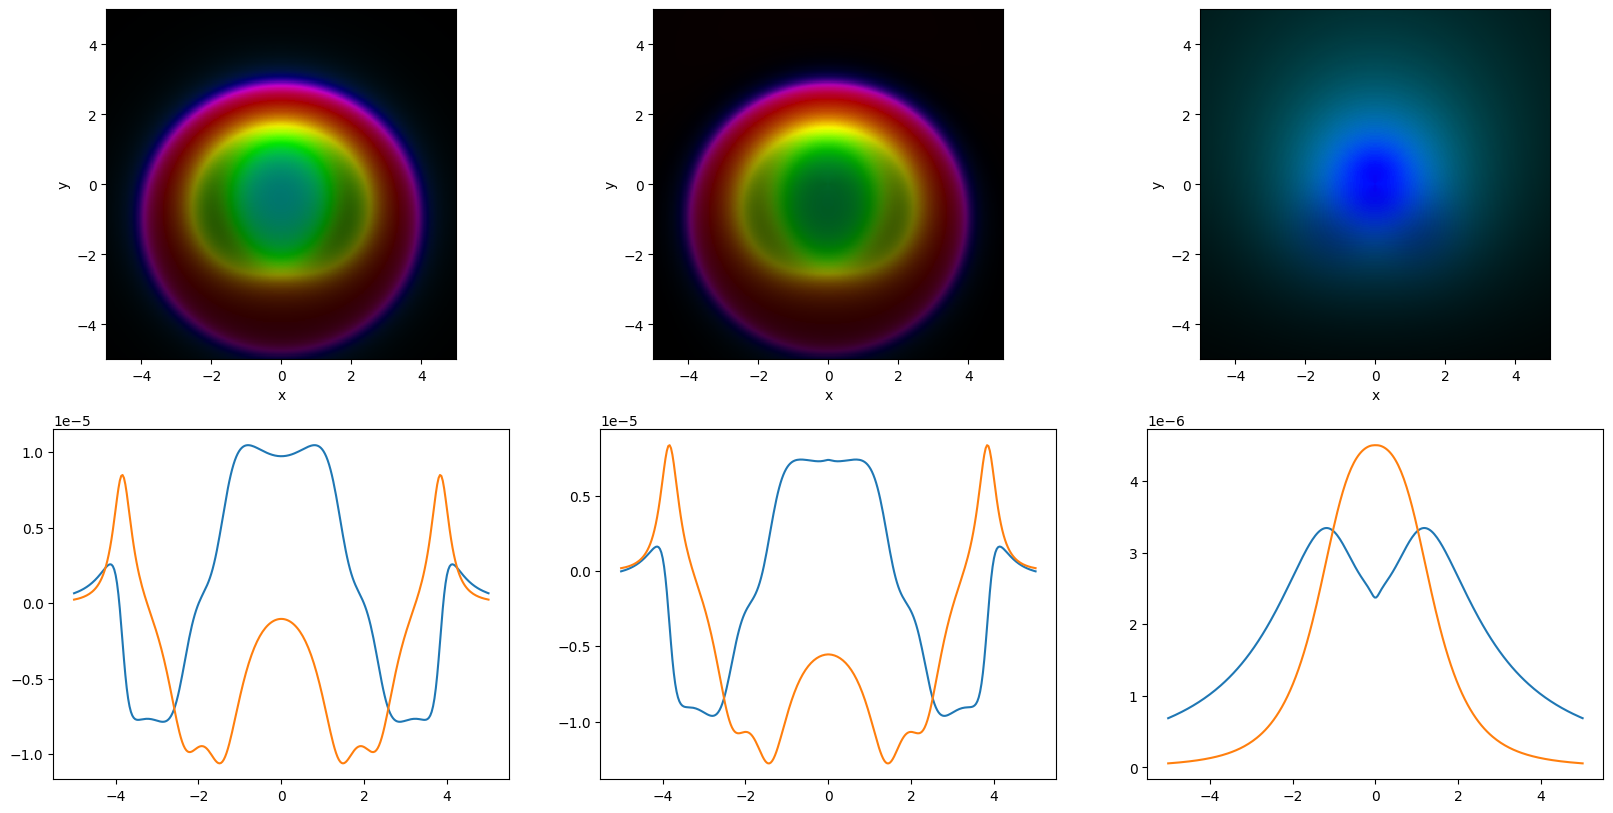

In [11]:
mass = -1+1j
term_eval.constant_args[m] = mass
ct_eval.constant_args[m] = mass
sub_eval.constant_args[m] = mass

plot_subtraction(term_eval,ct_eval,sub_eval)

# This breaks because we the energy is evaluated on the wrong sheet

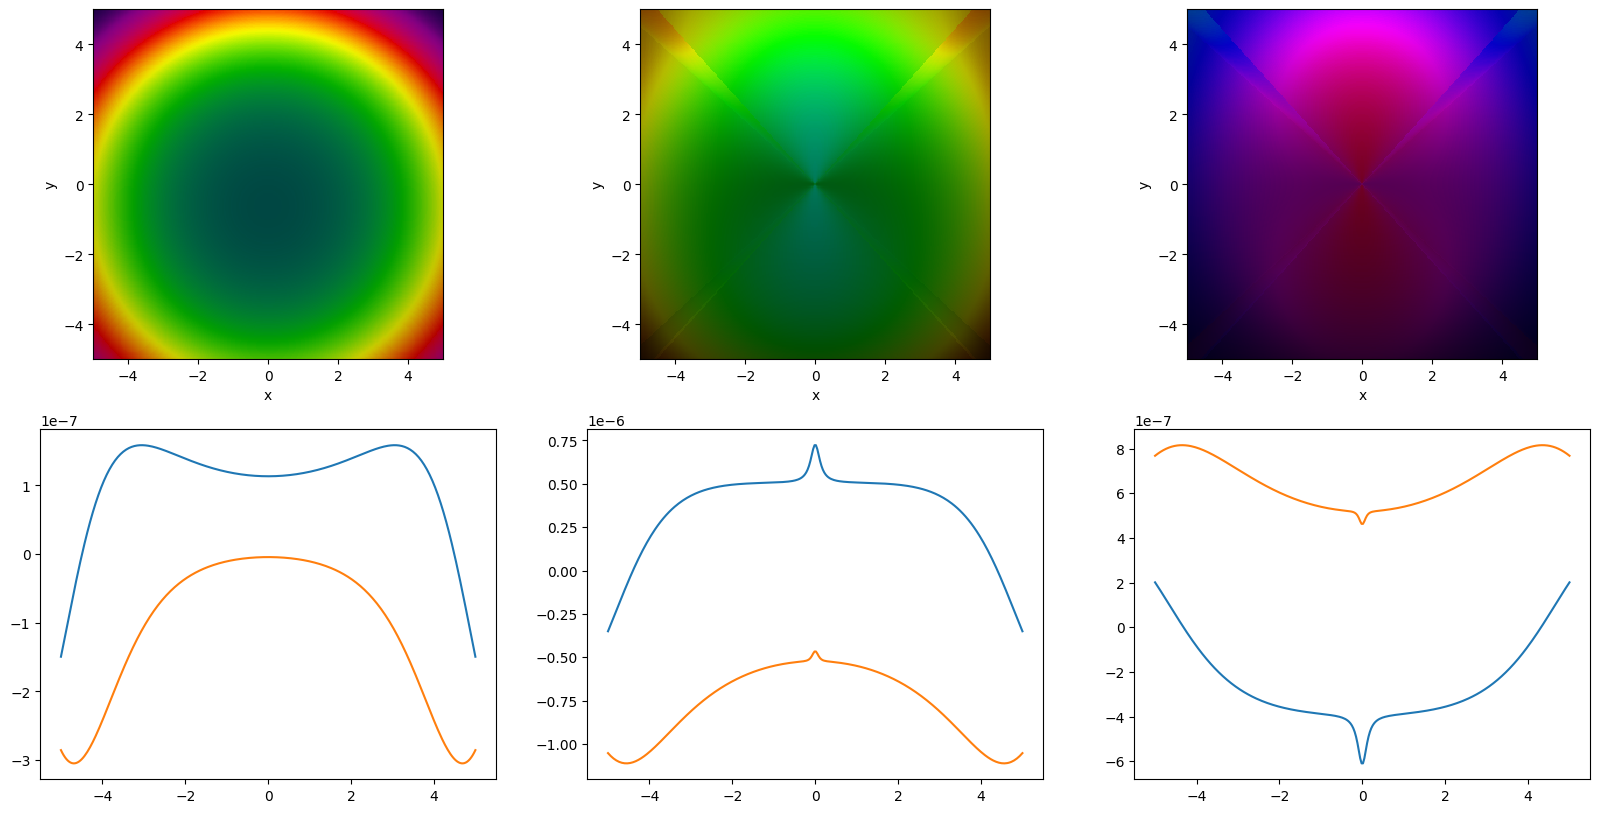

In [12]:
mass = 2-5j
term_eval.constant_args[m] = mass
ct_eval.constant_args[m] = mass
sub_eval.constant_args[m] = mass

plot_subtraction(term_eval,ct_eval,sub_eval)

# Next steps:

- create test cases for diffrent cases of intersections
- numerically integrate
- compute counter term integral
- compare
- automatically compute all the centers

In [13]:
from symbolica import E

test = E("OSE(1)")

test_with_ose = test.replace(E("OSE(x_)"), E("sqrt(dot(k - q(x_)) + m^2)"))
